In [61]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl
#make sure to install keras if you don't have the package yet
from keras import layers, models
import h5py

# Start With PFS

In [62]:
def parse_data(filepath):
    f = h5py.File(filepath,'r')
    a_group_key = list(f.keys())[0]
    dset = f[a_group_key]
    data = dset[:]
    df = pd.DataFrame(data)
    df.sequence = df.sequence.str.decode('utf-8')
    return df

def encode_pfs(sequence):
    output = np.zeros(6*4)
    for i in range(3):
        if sequence[i] == 'A':
            output[4*i + 0] = 1
        elif sequence[i] == 'C':
            output[4*i + 1] = 1
        elif sequence[i] == 'G':
            output[4*i + 2] = 1
        elif sequence[i] == 'T':
            output[4*i + 3] = 1
    
    for i in range(3):
        if sequence[-3+i] == 'A':
            output[4*(i+3) + 0] = 1
        elif sequence[-3+i] == 'C':
            output[4*(i+3) + 1] = 1
        elif sequence[-3+i] == 'G':
            output[4*(i+3) + 2] = 1
        elif sequence[-3+i] == 'T':
            output[4*(i+3) + 3] = 1
    return output


def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(int(30/1.5),int(15/1.5)),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()

In [63]:
# Below is an Example of encoding the PFS of a certain sequence

In [64]:
encode_pfs("ACGTTTTCCT")

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1.])

# Clean

## Dataset 1

In [65]:
df1 = parse_data('data/jami_raw/0406_cr4_pfs_kd_fitting_filtered25_free_Imax_yint_capped')
PERFECT_KD = df1[df1.sequence == 'GTACCATAGAGAGGTTATCCGCTCACCG'].iloc[0]['kd']
df1['ABA'] = -(df1.kd/PERFECT_KD).apply(np.log)

In [66]:
df1.head()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count,ABA
0,GAACCATAGAGAGGTTATCCGCTCACAG,56.035508,58.977928,31486.888693,36749.627898,34,-1.617189
1,TAGCCATAGAGAGGTTATCCGCTCATTA,26.246193,5.312386,30000.000000,39501.646393,63,-0.858725
2,GTTCCATAGAGAGGTTATCCGCTCAATT,16.568171,1.494417,30223.060029,38315.028391,102,-0.398687
3,TAGCCATAGAGAGGTTATCCGCTCATTT,29.371625,3.287853,30621.221003,39412.614477,84,-0.971233
4,ACCCCATAGAGAGGTTATCCGCTCACGG,18.309269,9.601294,30000.000000,37545.272601,11,-0.498611


<AxesSubplot:>

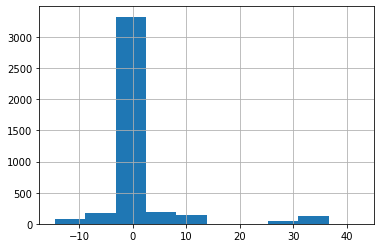

In [67]:
df1.ABA.hist()

In [68]:
#filt_df1 = df1[df1.ABA.abs() < 3]
filt_df1 = df1[(df1.kd> 1) & (df1.kd < 128)]

In [69]:
X = np.array([encode_pfs(seq) for seq in filt_df1.sequence])
y = np.array(filt_df1.ABA).T

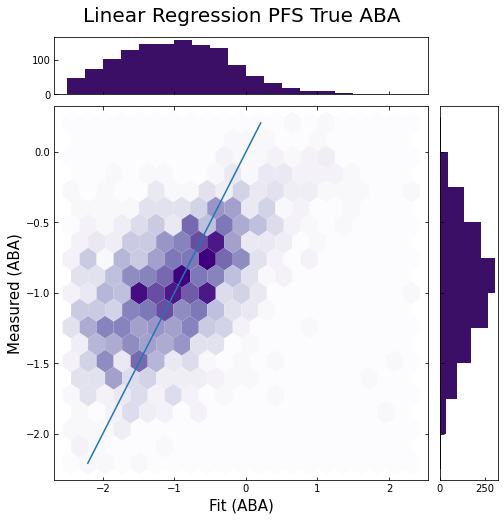

test correlation is 0.5160526122626224


In [70]:
#just to show that we aren't really over-fitting
X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression PFS True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

## Dataset 2

In [42]:
df2 = parse_data('data/jami_raw/0409_cr4_pfs_kd_fitting_filtered25_free_Imax_yint_capped')
PERFECT_KD = df2[df2.sequence == 'GTACCATAGAGAGGTTATCCGCTCACCG'].iloc[0]['kd']
df2['ABA'] = -(df2.kd/PERFECT_KD).apply(np.log)

In [43]:
df2.head()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count,ABA
0,CGTCCATAGAGAGGTTATCCGCTCAGCG,0.585261,0.438127,33694.432559,31610.677688,59,1.633276
1,TAGCCATAGAGAGGTTATCCGCTCATTC,10.936183,1.747827,30373.769311,35501.329408,52,-1.294499
2,GTTCCATAGAGAGGTTATCCGCTCAGCA,12.179985,13.089079,30702.117213,32467.838662,74,-1.402216
3,TAGCCATAGAGAGGTTATCCGCTCATTG,8.917166,0.768287,30612.119511,37391.765276,83,-1.090400
4,GAACCATAGAGAGGTTATCCGCTCACAT,104.880012,93.930836,30000.000000,36379.930577,26,-3.555239


<AxesSubplot:>

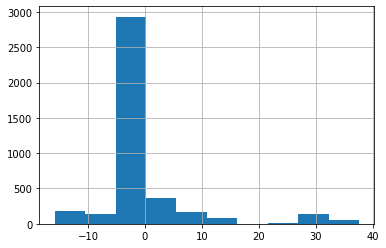

In [44]:
df2.ABA.hist()

In [46]:
#filt_df2 = df2[df2.ABA.abs() < 3]
filt_df2 = df2[(df2.kd> 1) & (df2.kd < 128)]

In [47]:
X = np.array([encode_pfs(seq) for seq in filt_df2.sequence])
y = np.array(filt_df2.ABA).T

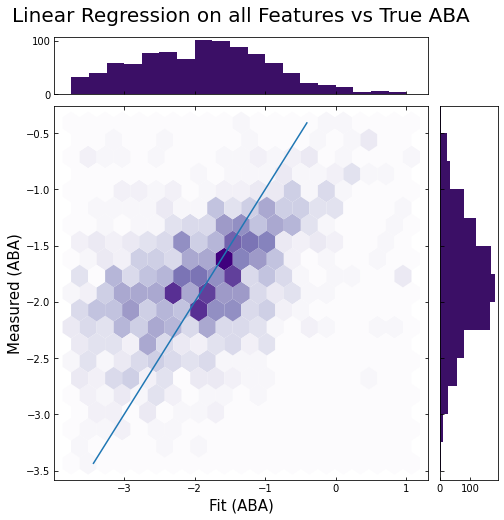

test correlation is 0.4783827462268958


In [48]:
#just to show that we aren't really over-fitting
X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

In [49]:
## Mean of Datasets 1 and 2

In [55]:
df3 = df1.merge(df2, on='sequence')
df3['ABA'] = -((df3.kd_x+df3.kd_y)/(2*PERFECT_KD)).apply(np.log)
df3['kd'] = (df3.kd_x+df3.kd_y)/2

<AxesSubplot:>

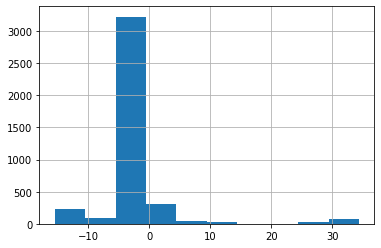

In [51]:
df3.ABA.hist()

In [56]:
#filt_df3 = df3[df3.ABA.abs() < 3]
filt_df3 = df3[(df3.kd> 1) & (df3.kd < 128)]

In [57]:
X = np.array([encode_pfs(seq) for seq in filt_df3.sequence])
y = np.array(filt_df3.ABA).T

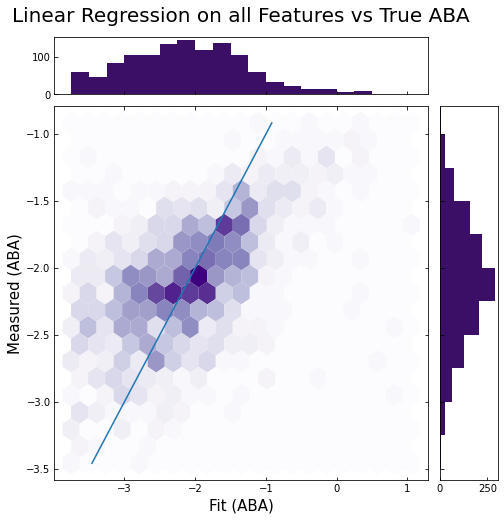

test correlation is 0.5399139911616805


In [58]:
#just to show that we aren't really over-fitting
X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)